# [学习JVM是如何从入门到放弃的？(修订版)](https://mp.weixin.qq.com/s?__biz=MzI4Njg5MDA5NA==&mid=2247484721&idx=2&sn=73b2762abd8c54cdc8b6bb8b5692384b&chksm=ebd74430dca0cd262c0cd72509e8e9df71287eb74d3e3e56430934df7c60db38a78824a80a4a&token=1676899695&lang=zh_CN###rd)

## 先来看看简单的Java程序
可以在命令行用`javac`来编译 `.java`文件代码，用 `java` 命令来执行编译后生成的 .class文件。

在使用**IDE**点击运行的时候其实就是将这两个命令**结合**起来了(编译并运行)，方便我们开发。

In [3]:
public class JavaClass{
    private String name;
    private int age;
    //...some getter/setter and toString
    public void setName(String name){
        this.name = name;
    }
    
    public String getName(){
        return name;
    } 
    
    public void setAge(int age){
        this.age = age;
    }
    
    public int getAge(){
        return age;
    }
    
    public String toString(){
        return "name："+name+ "\n"+
        "age："+age;
    }
}

In [6]:
// Test class
public class JavaClassTest{
    public static void test(){
    
        JavaClass javaClass = new JavaClass();
        javaClass.setName("anlzou");
        System.out.println(javaClass);
    }
}

JavaClassTest.test();

name：anlzou
age：0


## 编译过程
`.java`文件是由Java源码编译器(上述所说的javac.exe)来完成，流程图如下所示：
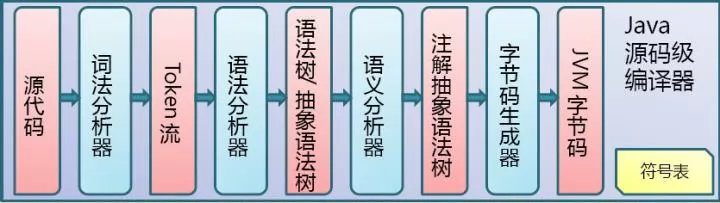
Java源码编译由以下三个过程组成：
- 分析和输入到符号表
- 注解处理
- 语义分析和生成class文件
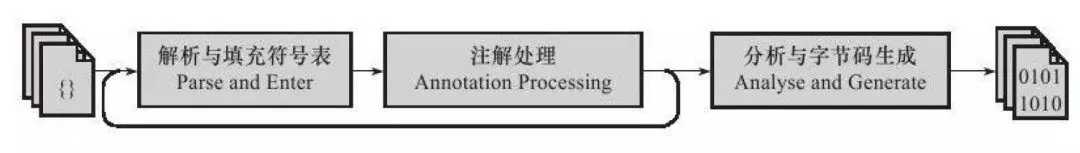

### 编译时期-语法糖
> 语法糖可以看做是**编译器实现的一些“小把戏”**，这些“小把戏”可能会使得**效率“大提升”。**

最值得说明的就是**泛型**了，这个语法糖可以说我们是经常会使用到的！

泛型只会在Java源码中存在，**编译过后**会被替换为原来的原生类型（Raw Type，也称为裸类型）了。这个过程也被称为：**泛型擦除。**

有了泛型这颗语法糖以后：
- 代码更加简洁（不用强制转换）
- 程序更加健壮（只要编译时期没有警告，那么运行时期就不会出现ClassCastException异常）
- 可读性和稳定性（在编写集合的时候，就限定了类型）


## JVM实现跨平台
通过 `javac.exe` 编译器编译我们的 `.java` 源代码文件生成出 `.class` 文件了！

这些 `.class` 文件很明显是**不能直接运行**的，它不像C语言(编译cpp后生成exe文件直接运行)

这些 `.class` 文件是交**由JVM来解析运行**！

- JVM是运行在操作系统之上的，每个操作系统的指令是不同的，而**JDK是区分操作系统的**，只要你的本地系统装了JDK，这个JDK就是能够和当前系统兼容的。
- 而class字节码运行在JVM之上，所以**不用关心class字节码是在哪个操作系统编译的**，只要符合JVM规范，那么，这个字节码文件就是可运行的。
- 所以Java就做到了跨平台——一次编译，到处运行！

jdk是区分平台的，class文件会被“翻译”成不同平台的机器编码。

## class文件和JVM的恩怨情仇
### 类的加载时机
现在我们例子中生成的两个 `.class` 文件都会直接被加载到JVM中吗？？

虚拟机规范则是严格规定了有且只有5种情况必须立即对类进行“初始化”(class文件加载到JVM中)：
- 创建类的实例(new 的方式)。访问某个类或接口的静态变量，或者对该静态变量赋值，调用类的静态方法
- 反射的方式
- 初始化某个类的子类，则其父类也会被初始化

- ava虚拟机启动时被标明为启动类的类，直接使用java.exe命令来运行某个主类（包含main方法的那个类）
- 当使用JDK1.7的动态语言支持时(....)

所以说：
- Java类的**加载是动态**的，它并不会一次性将所有类全部加载后再运行，而是保证程序运行的**基础类(像是基类)完全加载到jvm中**，至于**其他类，则在需要的时候才加载**。这当然就是为了**节省内存开销**。

### 如何将类加载到jvm
class文件是通过**类的加载器**装载到jvm中的！

Java默认有**三种类加载器**：
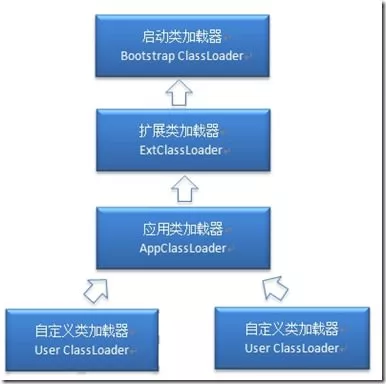
各个加载器的工作责任：

- 1）**Bootstrap ClassLoader**：负责加载`$JAVA_HOME`中`jre/lib/rt.jar`里所有的class，由C++实现，不是ClassLoader子类
- 2）**Extension ClassLoader**：负责加载java平台中**扩展功能**的一些jar包，包括`$JAVA_HOME`中`jre/lib/ext/*.jar`或`-Djava.ext.dirs`指定目录下的jar包
- 3）**App ClassLoader**：负责记载**classpath**中指定的jar包及目录中class

工作过程：
- 1、当AppClassLoader加载一个class时，它首先不会自己去尝试加载这个类，而是把类加载请求委派给父类加载器ExtClassLoader去完成。
- 2、当ExtClassLoader加载一个class时，它首先也不会自己去尝试加载这个类，而是把类加载请求委派给BootStrapClassLoader去完成。
- 3、如果BootStrapClassLoader加载失败（例如在$JAVA_HOME/jre/lib里未查找到该class），会使用ExtClassLoader来尝试加载；
- 4、若ExtClassLoader也加载失败，则会使用AppClassLoader来加载
- 5、如果AppClassLoader也加载失败，则会报出异常ClassNotFoundException

其实这就是所谓的**双亲委派模型**。简单来说：如果一个类加载器收到了类加载的请求，它首先不会自己去尝试加载这个类，而是把**请求委托给父加载器去完成，依次向上**。

好处：
- **防止内存中出现多份同样的字节码**(安全性角度)

特别说明：
- 类加载器在成功加载某个类之后，会把得到的 `java.lang.Class` 类的实例缓存起来。下次再请求加载该类的时候，类加载器会直接使用缓存的类的实例，而**不会尝试再次加载**。

### 类加载详细过程
加载器加载到jvm中，接下来其实又分了好几个步骤：
- 加载，查找并加载类的二进制数据，在**Java堆中也创建一个java.lang.Class类的对象**。
- 连接，连接又包含三块内容：验证、准备、初始化。     
    - 1）验证，文件格式、元数据、字节码、符号引用验证；     
    - 2）准备，为类的静态变量分配内存，并将其初始化为默认值；     
    - 3）解析，把类中的符号引用转换为直接引用
- 初始化，为类的静态变量赋予正确的初始值。
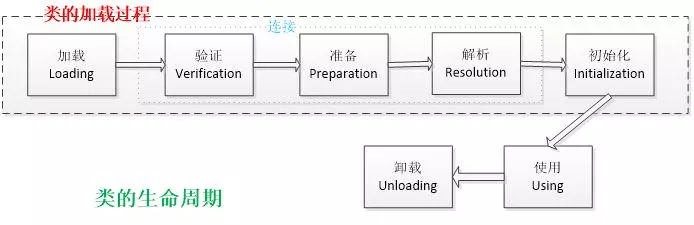

### JIT即时编辑器
一般我们可能会想：JVM在加载了这些class文件以后，针对这些字节码，逐条取出，**逐条执行—>解析器解析**。

但如果是这样的话，那就**太慢**了！

我们的JVM是这样实现的：
- 就是把这些Java字节码**重新编译优化**，生成机器码，让CPU直接执行。这样编出来的代码效率会更高。
- 编译也是要花费时间的，我们一般对**热点代码**做编译，**非热点代码直接解析**就好了。

    **热点代码，解释：**
    1. 多次调用的方法
    2. 多次执行的循环体

使用热点探测来**检测是否为热点代码**，热点探测有两种方式：
- 采样
- 计数器

目前HotSpot使用的是**计数器的方式**，它为每个方法准备了两类计数器：
- 方法调用计数器（Invocation  Counter）
- 回边计数器（Back  EdgeCounter）。
- 在确定虚拟机运行参数的前提下，这两个计数器都有一个确定的阈值，**当计数器超过阈值溢出了，就会触发JIT编译**。
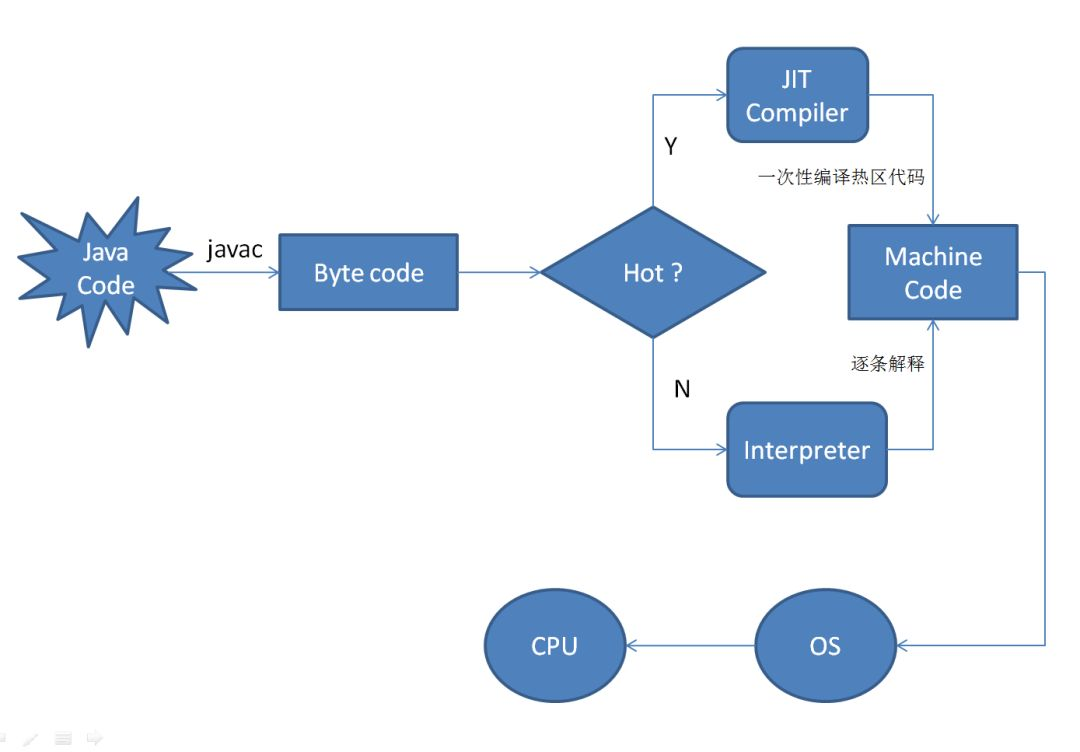

### 回到例子中
按我们程序来走，我们的 `JavaClassTest.class` 文件会被AppClassLoader加载器(因为ExtClassLoader和BootStrap加载器都不会加载它（双亲委派模）)加载到JVM中。

随后发现了要使用Java3y这个类，我们的 `JavaClassTest.class` 文件会被AppClassLoader加载器(因为ExtClassLoader和BootStrap加载器都不会加载它（双亲委派模型）)加载到JVM中

**详情参考：**

浅解JVM加载class文件
- https://www.mrsssswan.club/2018/06/30/jvm-start1/

JVM杂谈之JIT
- https://zhuanlan.zhihu.com/p/28476709

**扩展阅读：**

深入探讨 Java 类加载器
- https://www.ibm.com/developerworks/cn/java/j-lo-classloader

深入浅出 JIT 编译器
- https://www.ibm.com/developerworks/cn/java/j-lo-just-in-time/

Java 类加载器（ClassLoader）的实际使用场景有哪些？
- https://www.zhihu.com/question/46719811

## 类加载完以后JVM干了什么？
在类加载检查通过后，接下来虚拟机将**为新生对象分配内存**。

### JVM的内存结构
- 堆：**存放对象实例**，几乎所有的对象实例都在这里分配内存
- 虚拟机栈：虚拟机栈描述的是**Java方法执行的内存结构**：每个方法被执行的时候都会同时创建一个**栈帧**（Stack Frame）用于存储局部变量表、操作栈、动态链接、方法出口等信息
- 本地方法栈：本地方法栈则是为虚拟机使用到的**Native方法服务**。
- 方法区：存储**已被虚拟机加载的类元数据信息**(元空间)
- 程序计数器：当前线程所执行的字节码的**行号指示器**

### 例子中的流程
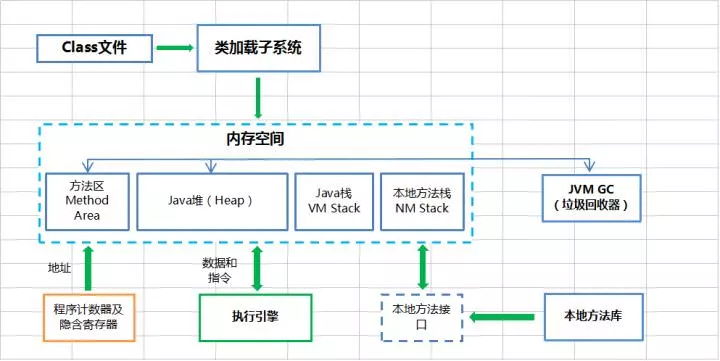
**宏观简述**一下例子中的工作流程：
1. 通过 `java.exe` 运行 `JavaClass.class`，随后被加载到JVM中，元空间存储着类的信息(包括类的名称、方法信息、字段信息......)。
2. 然后JVM找到JavaClassTest的主函数入口(main)，为main函数创建栈帧，开始执行main函数
3. main函数的第一条命令是 `JavaClass javaClass = new JavaClass()`;就是让JVM创建一个`JavaClass`对象，但是这时候方法区中没有`JavaClass`类的信息，所以JVM马上加载 `JavaClass` 类，把`JavaClass`类的类型信息放到方法区中(元空间)
4. 加载完`JavaClass`类之后，Java虚拟机做的第一件事情就是在堆区中为一个新的`JavaClass`实例分配内存, 然后调用构造函数初始化`JavaClass`实例，这个`JavaClass`实例持有着指向方法区的`JavaClass`类的类型信息（其中包含有方法表，java动态绑定的底层实现）的引用
5. 当使用 `javaClasss.setName("anlzou");`的时候，JVM根据`javaClass`引用找到`JavaClass`对象，然后根据`JavaClass`对象持有的引用定位到方法区中`JavaClass`类的类型信息的方法表，获得 `setName()`函数的字节码的地址
6. 为 `setName()`函数创建栈帧，开始运行 `setName()`函数

从微观上其实还做了很多东西，正如上面所说的**类加载过程**（加载-->连接(验证，准备，解析)-->初始化)，在类加载完之后jvm为其**分配内存**(分配内存中也做了非常多的事)。由于这些步骤并不是一步一步往下走，会有很多的“混沌bootstrap”的过程，所以很难描述清楚。

**扩展阅读(先有Class对象还是先有Object)：**
- https://www.zhihu.com/question/30301819

**参考资料：**

Java程序编译和运行的过程
- http://www.cnblogs.com/qiumingcheng/p/5398610.html
- Java JVM 运行机制及基本原理
- https://zhuanlan.zhihu.com/p/25713880